#Cognitive and Neural Dynamics Lab Tutorials
##Phase-Amplitude Coupling (PAC)

#####Torben Noto 2015


#### Neural Oscillations can be embedded within each other.
There are many ongoing oscillations in the brain and **features of oscillations in different frequency bands can interact with each other**. Phase Amplitude coupling (PAC) measures how much the amplitude of a fast oscilation is related to the phase of a slower oscillation. This has been proposed as a mechanism that different brain regions may use to communicate.

In this notebook, we'll investigate phase amplitude coupling in ECoG data. We'll explore how much 
the phase of Theta(4-8 Hz) is coupled with the amplitude of High Gamma(80-150 Hz). If that definition isn't intuitive now, it will make more sense later on.

I recommend that you read the filtering and/or PSD tutorials before reading this if you are not familiar at all with filters and frequency analyses.

In [125]:
#importing modules
%config InlineBackend.figure_format = 'retina'
%pylab inline
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.io
import scipy.signal
from scipy.signal import butter, filtfilt, hilbert

Populating the interactive namespace from numpy and matplotlib


In [126]:
#loading ECoG data from local save
filename = 'emodat.mat'
filename = os.path.join('/Users/Torben/Desktop/Voytek_things/', filename)
data = sp.io.loadmat(filename)
srate = data['srate'];
data = data['data']; # time series
data = data[0, :];

First, we're going to need some functions that filter for the frequencies that we're interested in. See the filtering tutorial if you want to know more about this.

In [127]:
#filtering functions
def butter_bandpass(lowcut, highcut, fs, order=4):
    #lowcut is the lower bound of the frequency that we want to isolate
    #hicut is the upper bound of the frequency that we want to isolate
    #fs is the sampling rate of our data
    nyq = 0.5 * fs #nyquist frequency - see http://www.dspguide.com/ if you want more info
    low = float(lowcut) / nyq
    high = float(highcut) / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(mydata, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, mydata)
    return y

Here we're going to use the functions that we made to calculate the PAC

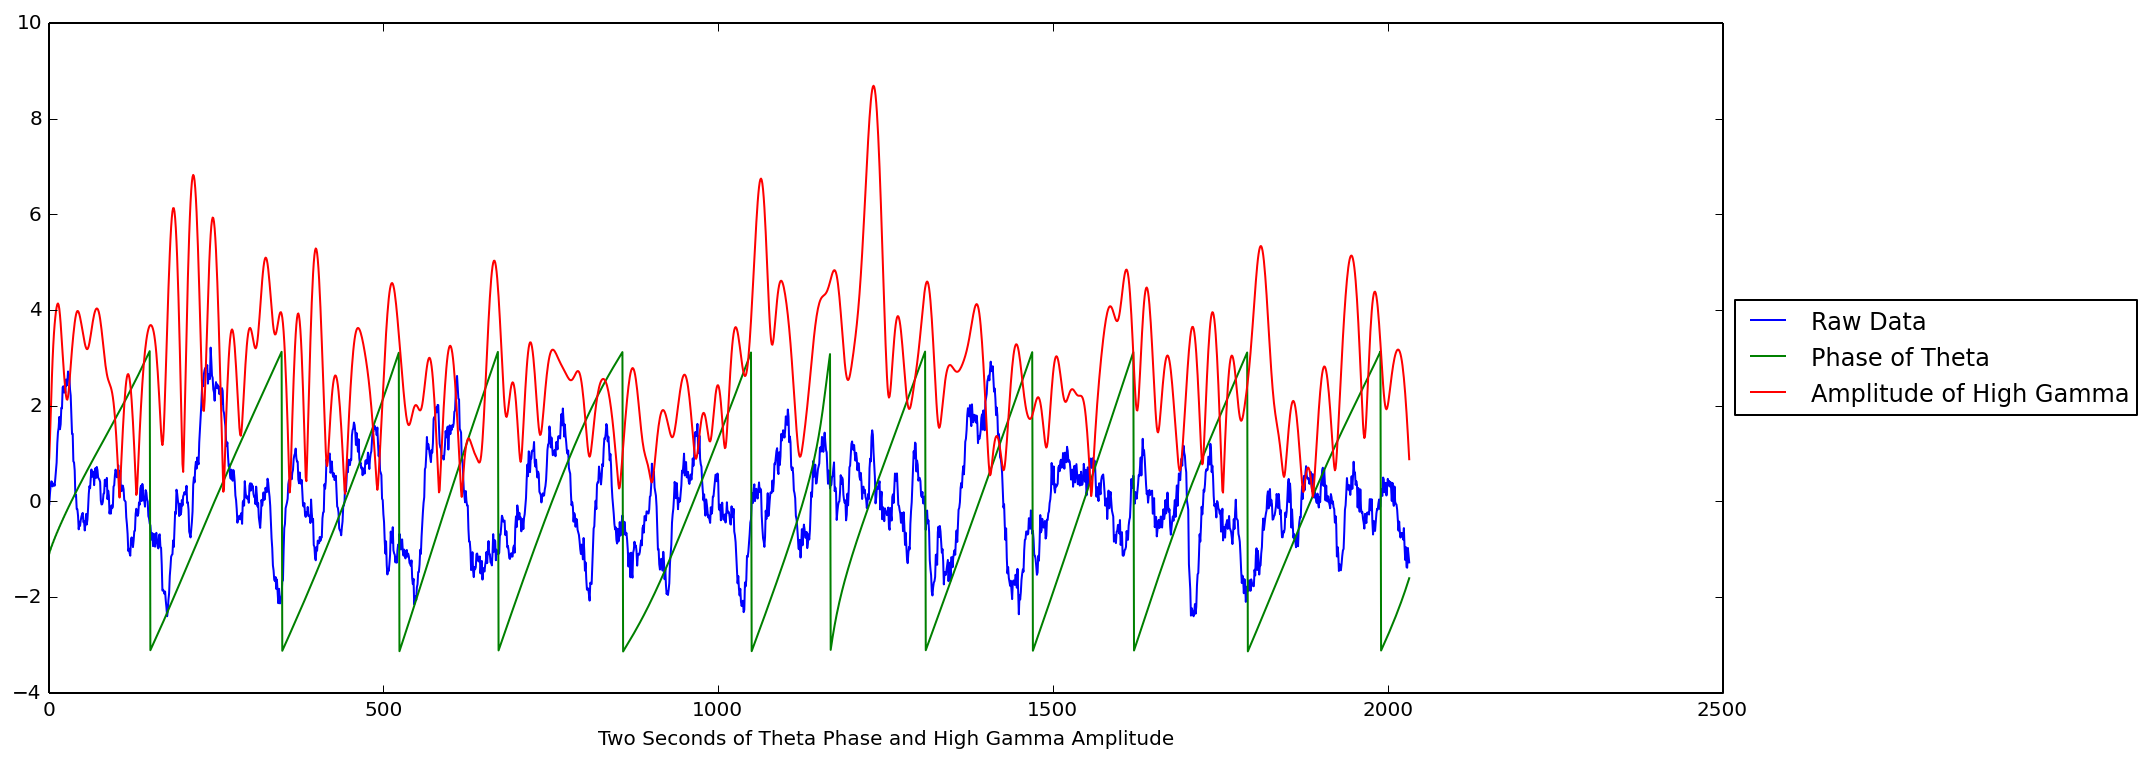

In [128]:
#parameters
phase_providing_band = [4,8]; #4-8 Hz band
amplitude_providing_band = [80, 125]; #80-125 Hz band

#calculating phase of theta
phase_data = butter_bandpass_filter(data, phase_providing_band[0], phase_providing_band[1], round(srate));
phase_data = hilbert(phase_data);
phase_data = angle(phase_data);

#calculating amplitude envelope of high gamma
amp_data = butter_bandpass_filter(data, amplitude_providing_band[0], amplitude_providing_band[1], round(srate));
amp_data = hilbert(amp_data);
amp_data = abs(amp_data);

#let's look at a small chunk of our data
figure(figsize = (15,6));
plot((data[1:int(srate)*2]-mean(data[1:int(srate)*2]))/std(data[1:int(srate)*2]),label= 'Raw Data'); #normalized raw data
plot(phase_data[1:int(srate)*2],label= 'Phase of Theta');
plot(amp_data[1:int(srate)*2],label= 'Amplitude of High Gamma'); 
xlabel('Two Seconds of Theta Phase and High Gamma Amplitude')
legend(loc='center left', bbox_to_anchor=(1, 0.5))

In the graph above, I'm plotting the raw data, the phase of theta, and the amplitude of high gamma.

First of all, notice that in the raw data, there are fast, small bumps and slow, big bumps. When we filter the data for high gamma and theta, we are seperating out these components of the signal. You can see that in the filtered signals - the peaks of the high gamma signal (red) line up with the fast oscillations in the raw signal, while the theta phase (green) lines up well with the slower oscilation.

Most importantly, you should notice, that there seems to be a positive correlation between the height of the high gamma oscilation and the phase of the theta oscillaion. This is the phenomenon that we're trying to capture with PAC. If you don't believe that there is a real relationship, see how this is calculated below.

We hypothesize that there is a correlation between theta phase and high gamma amplitude but we can't do a simple pearson correlation here because the phase of theta is periodic (between -pi and pi), and you'll get incorrect results if you run a pearson on periodic data.

To get past this, we're going to make a function that correctly correlates periodic data with linear data. 

In [129]:
def circCorr(ang,line):
    n = len(ang)
    rxs = sp.stats.pearsonr(line,sin(ang))
    rxs = rxs[0]
    rxc = sp.stats.pearsonr(line,cos(ang))
    rxc = rxc[0]
    rcs = sp.stats.pearsonr(sin(ang),cos(ang))
    rcs = rcs[0]
    rho = sqrt((rxc**2 + rxs**2 - 2*rxc*rxs*rcs)/(1-rcs**2)) #r
    r_2 = rho**2 #r squared
    pval = 1- sp.stats.chi2.cdf(n*(rho**2),1)
    standard_error = sqrt((1-r_2)/(n-2))

    return rho, pval, r_2,standard_error

print circCorr(phase_data, amp_data)

(0.054580779410983112, 0.0, 0.0029790614811103979, 0.00082187185052462095)


The values above represent the r, p, r^2 and standard of error respectively. The values that we got show that there is a significant correlation between theta phase and high gamma amplitude that explains about 5% of the variance. Cool.

However, this measure doesn't tell us what phase the amplitude is synced to. The code in the next cell can help us visualize that.

34


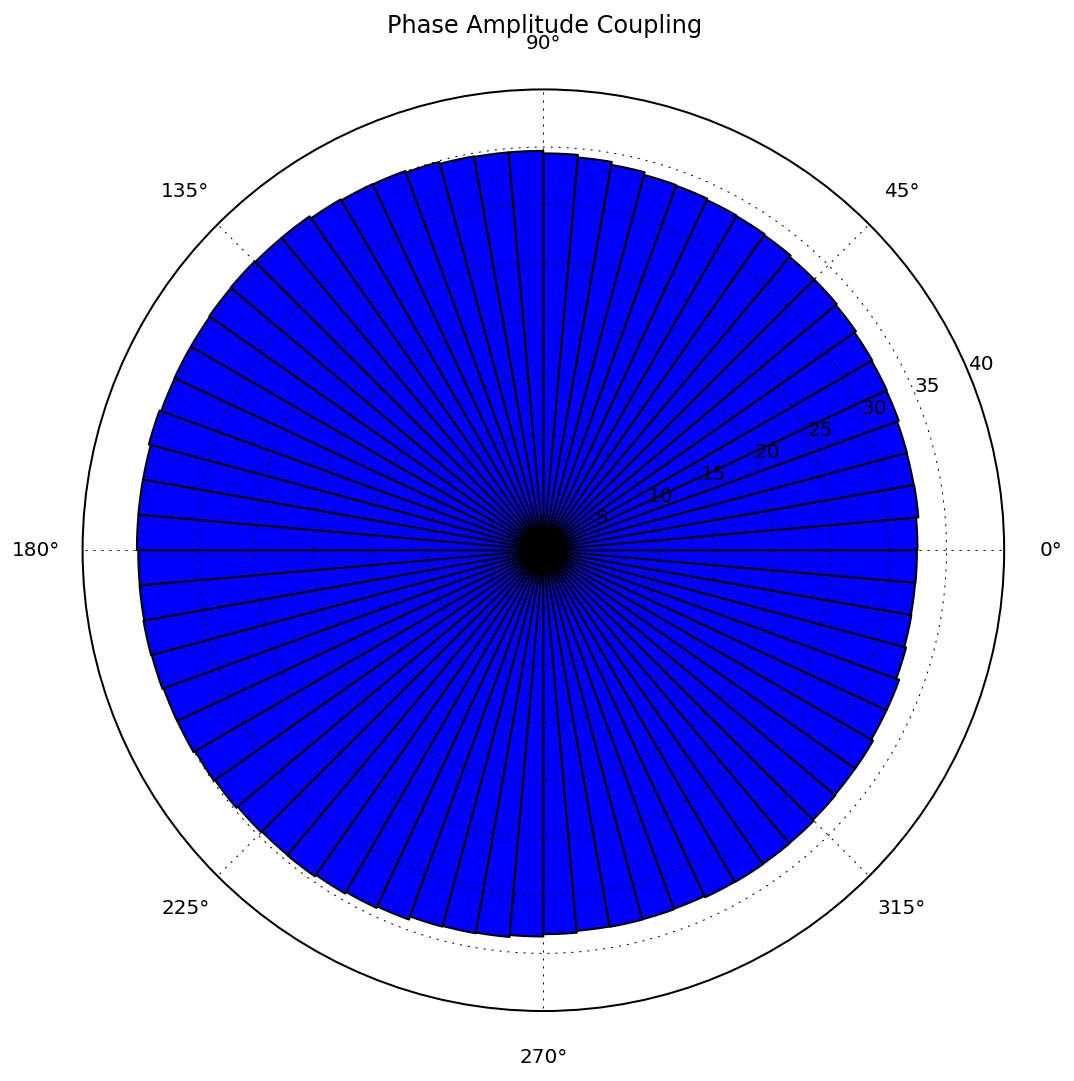

In [124]:
#this takes a while to run. 
#If you make bin_size larger (36) it will run much quicker but the effect won't be as clear.
bin_size = 5; 
bins = range(-180,180+bin_size,bin_size); 
bins = dot(bins, 0.0174532925);

amps = [];

#filling phase bins with amplitudes
for x in xrange(len(bins)-1):
    amps_above_lo_bound = find(phase_data >= bins[x]);
    amps_below_hi_bound = find(phase_data < bins[x+1]);
    amps_below_hi_bound = set(amps_below_hi_bound);
    amp_inds_in_this_bin = [amp_val for amp_val in amps_above_lo_bound if amp_val in amps_below_hi_bound]
    amps_in_this_bin = amp_data[amp_inds_in_this_bin];
    amps.append(mean(amps_in_this_bin));

bins = bins[:len(bins)-1];

#normalizing to make the effect more clear
amps = (amps-mean(amps))/std(amps);
amps = amps+argmin(amps);
print argmin(amps);

#plotting figure;
fig = figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
ax.bar(bins, amps, width=bins[1]-bins[0], bottom=0.0)
title('Phase Amplitude Coupling');

In the figure above, the amplitude of high gamma steadily gets greater at 180 degrees into the theta phase.
In the first figure, you'll notice that 180 degrees into theta phase is the peak of the oscillation.

In this module, we learned that we can examine the relationship between the phase of a slow wave 
and the amplitude of a faster wave.
To isolate the frequency ranges that we want, we use filters then do some math to get the phase
and amplitude of the waves that we're interested in.
Then we can use statistics to quantify the relationship between the two.
In this example we have shown that, in our data, the amplitude of high gamma is biased to be larger at the peak of theta. This is a small but significant correlation. Many studies have shown that PAC influences information tranfer, perception, and behavior.

PAC is a relatively new and understudied technique.  PAC can also be calculated in specific time windows such as timing around events or along a sliding window (see sliding window PAC NN tutorial)
